In [1]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import pandas as pd
import numpy as np
 
# 构建Doc2vec模型，获得句子向量
def get_sentence_vec(datasets):
    # gemsim里Doc2vec模型需要的输入为固定格式，输入样本为[句子，句子序号]
    documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(datasets)]
    # 初始化和训练模型
    model = Doc2Vec(documents, vector_size=500, dm=1, window=4, min_count=5)
    #model = Doc2Vec(vector_size=300, dm=1, window=4, min_count=5, epochs=50)
    #model.build_vocab(documents)
    model.train(documents,total_examples=model.corpus_count,epochs=model.epochs)
 
    return model

In [2]:
data = pd.read_csv('./新华社数据.csv', encoding='gb18030')
data.head()

,id,author,source,content,feature,title,url
0,89617,NaN,快科技@http://www.kkj.cn/,此外，自本周（6月12日）起，除小米手机6等15款机型外，其余机型已暂停更新发布（含开发版/...,"{""type"":""科技"",""site"":""cnbeta"",""commentNum"":""37""...",小米MIUI 9首批机型曝光：共计15款,http://www.cnbeta.com/articles/tech/623597.htm
1,89616,NaN,快科技@http://www.kkj.cn/,骁龙835作为唯一通过Windows 10桌面平台认证的ARM处理器，高通强调，不会因为只考...,"{""type"":""科技"",""site"":""cnbeta"",""commentNum"":""15""...",骁龙835在Windows 10上的性能表现有望改善,http://www.cnbeta.com/articles/tech/623599.htm
2,89615,NaN,快科技@http://www.kkj.cn/,此前的一加3T搭载的是3400mAh电池，DashCharge快充规格为5V/4A。\r\n...,"{""type"":""科技"",""site"":""cnbeta"",""commentNum"":""18""...",一加手机5细节曝光：3300mAh、充半小时用1天,http://www.cnbeta.com/articles/tech/623601.htm
3,89614,NaN,新华社,这是6月18日在葡萄牙中部大佩德罗冈地区拍摄的被森林大火烧毁的汽车。新华社记者张立云摄\r\n,"{""type"":""国际新闻"",""site"":""环球"",""commentNum"":""0"",""j...",葡森林火灾造成至少62人死亡 政府宣布进入紧急状态（组图）,http://world.huanqiu.com/hot/2017-06/10866126....
4,89613,胡淑丽_MN7479,深圳大件事,（原标题：44岁女子跑深圳约会网友被拒，暴雨中裸身奔走……）\r\n@深圳交警微博称：昨日清...,"{""type"":""新闻"",""site"":""网易热门"",""commentNum"":""978"",...",44岁女子约网友被拒暴雨中裸奔 交警为其披衣相随,http://news.163.com/17/0618/00/CN617P3Q0001875...


In [3]:
target =[]
for t in data['source']:
    if '新华社' in str(t):
        target.append(1)
    else:
        target.append(0)

In [4]:
text = list(data['content'])

In [5]:
import re
def token(string):
    return re.findall('\w+', string)

In [6]:
text_clean = [''.join(token(str(a))) for a in text]

In [7]:
model = get_sentence_vec(text_clean) 
sen_vec = [model.infer_vector(sen.split(' ')) for sen in text_clean]

In [8]:
len(target) == len(sen_vec)

True

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(sen_vec, target, test_size=0.2, random_state=0)

In [10]:
# SVM
from sklearn.svm import SVC
cls = SVC()
cls.fit(X_train, y_train)

D:\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [11]:
y_pred = cls.decision_function(X_test)

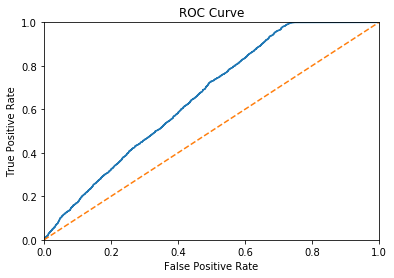

In [28]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
fpr_svm, tpr_svm, threshold = roc_curve(y_test, y_pred[:,1])
fig, ax = plt.subplots()
ax.plot(fpr_svm, tpr_svm)
ax.plot([0,1],[0,1], ls='--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [13]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(n_estimators=100, max_depth=10)
rnd_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [17]:
y_pred = rnd_clf.predict_proba(X_test)

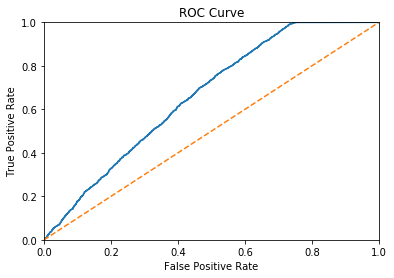

In [19]:
import matplotlib.pyplot as plt
fpr_rf, tpr_rf, threshold = roc_curve(y_test, y_pred[:,1])
fig, ax = plt.subplots()
ax.plot(fpr_rf, tpr_rf)
ax.plot([0,1],[0,1], ls='--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [22]:
# XGBoost
from xgboost import XGBClassifier
xg = XGBClassifier()
xg.fit(np.array(X_train), y_train)


XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [23]:
import numpy as np
y_pred = xg.predict_proba(np.array(X_test))

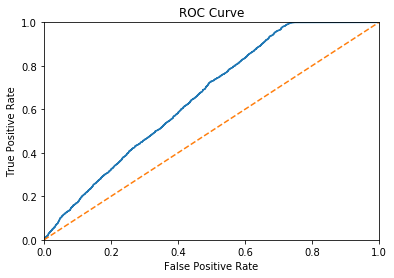

In [25]:
fpr_xgb, tpr_xgb, threshold = roc_curve(y_test, y_pred[:,1])
fig, ax = plt.subplots()
ax.plot(fpr_xgb, tpr_xgb)
ax.plot([0,1],[0,1], ls='--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

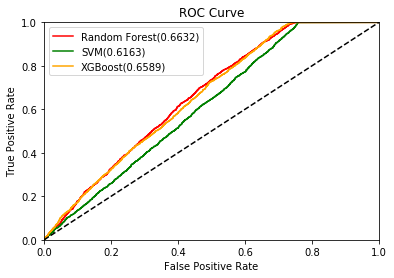

In [27]:
from sklearn.metrics import auc
fig, ax = plt.subplots()
ax.plot(fpr_rf, tpr_rf, color='red', label='Random Forest({:.4f})'.format(auc(fpr_rf, tpr_rf)))
ax.plot(fpr_svm, tpr_svm, color='green', label='SVM({:.4f})'.format(auc(fpr_svm, tpr_svm)))
ax.plot(fpr_xgb, tpr_xgb, color='orange', label='XGBoost({:.4f})'.format(auc(fpr_xgb, tpr_xgb)))
ax.plot([0,1],[0,1], ls='--', color='black')
plt.xlim([0,1])
plt.ylim([0,1])
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()